In [14]:
# Interactive plotting
%matplotlib widget

# Plotting configurations and imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams['font.size'] = 25
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.major.size']=   10
plt.rcParams['ytick.minor.size']=   6
plt.rcParams['xtick.major.size']=   10
plt.rcParams['xtick.minor.size']=   6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.pad']='7'
from matplotlib import ticker
from matplotlib.ticker import (
    LogFormatterMathtext,
    LogLocator,
    MaxNLocator,
    NullLocator,
    ScalarFormatter,
    AutoLocator,
    FixedLocator
)

import pandas as pd
import numpy as np
import matplotlib.cm as cm

/var/folders/hv/l8n0xl654pn93nm5rs3yyvnh0000gn/T/ipykernel_23837/3667167571.py:38: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(cs.collections):
/Users/mguolop1/anaconda3/envs/astroconda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


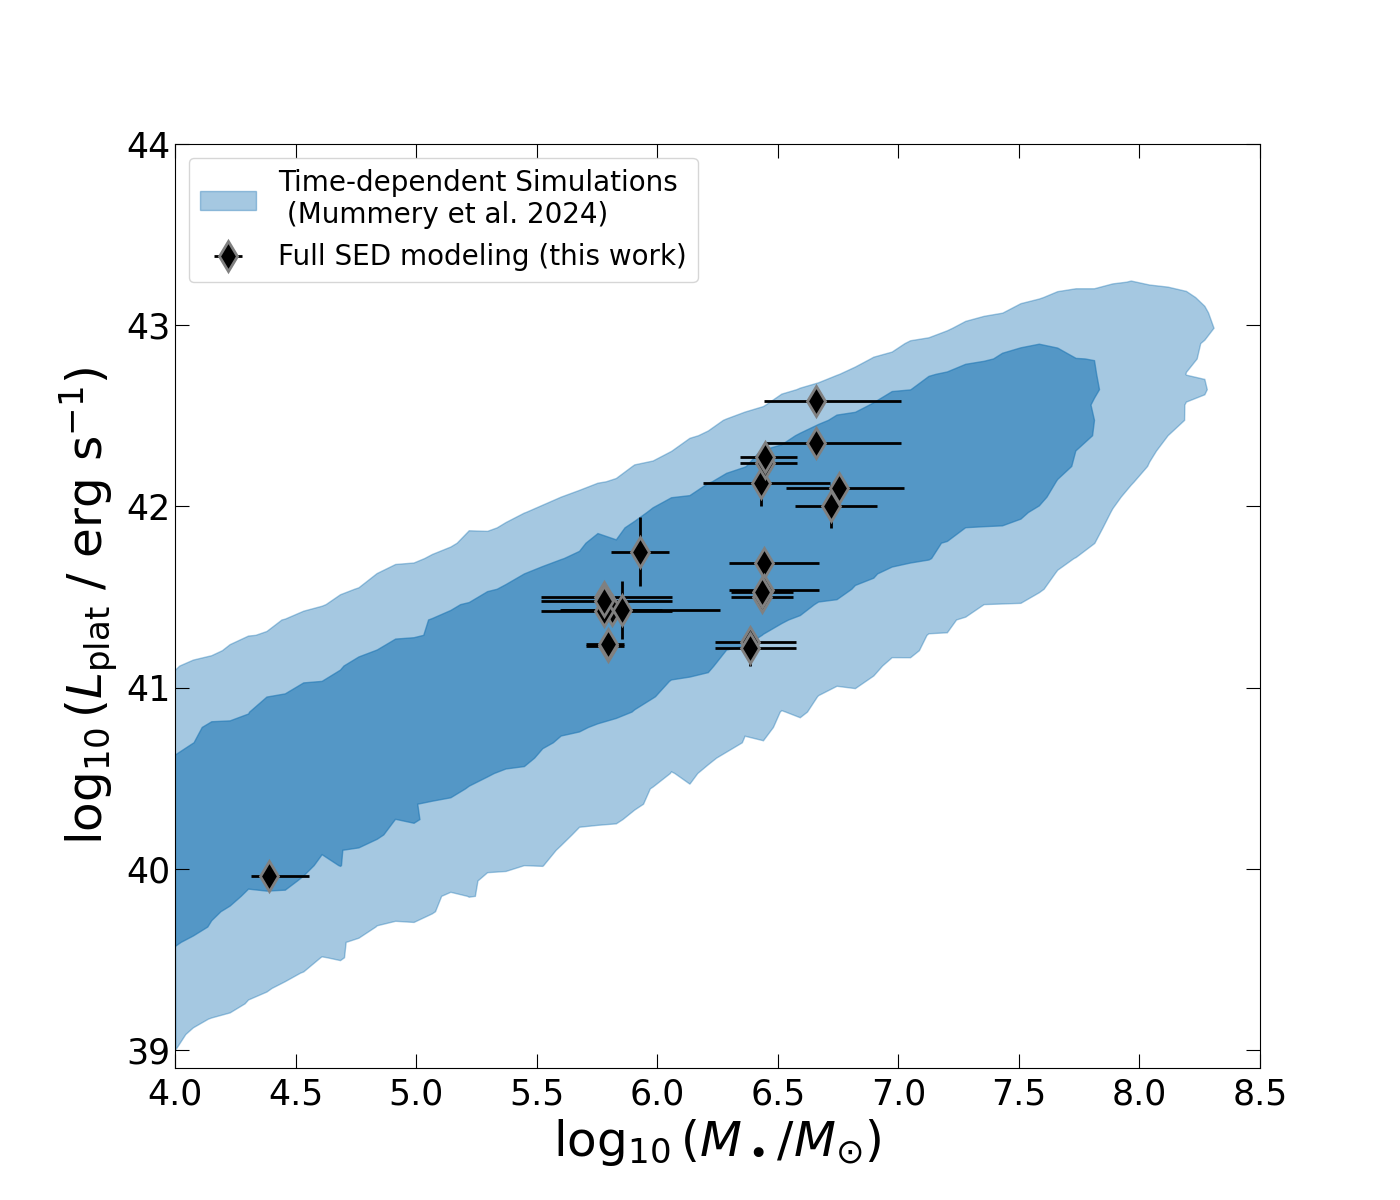

In [43]:
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_xlim(4.,8.5)
ax.set_ylim(38.9, 44)

ax.set_xlabel(r"$\log_{10}(M_{\rm \bullet}/M_{\odot})$", fontsize=35)
ax.set_ylabel(r"$\log_{10}(L_{\rm plat} \ / \ {\rm erg \ s^{-1}})$", fontsize=35)

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

x = np.log10(np.load("Mbhs_Muryel.npy"))
y =np.log10(np.load("vLvs_Muryel.npy"))

# Define grid
xbins = np.linspace(4, 8.5, 60)
ybins = np.linspace(39, 44, 60)
H, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])

# Get thresholds for 68% and 90%
Hflat = H.flatten()
Hsort = np.sort(Hflat)[::-1]
cdf = np.cumsum(Hsort) / np.sum(Hsort)
level68 = Hsort[np.searchsorted(cdf, 0.68)]
level90 = Hsort[np.searchsorted(cdf, 0.95)]

# Build mesh matching H.shape
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")


# Generate contours (don't plot lines)
cs = ax.contour(X, Y, H, levels=[level90, level68], colors="none")

# Fill regions
for i, collection in enumerate(cs.collections):
    for path in collection.get_paths():
        vertices = path.vertices
        if i == 0:  # 90%
            ax.fill(vertices[:, 0], vertices[:, 1], color="tab:blue", alpha=0.4, label="Time-dependent Simulations"+ '\n'+" (Mummery et al. 2024)")
        elif i == 1:  # 68%
            ax.fill(vertices[:, 0], vertices[:, 1], color="tab:blue", alpha=0.6)



ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_offset_text().set_visible(False)

table = pd.read_csv('properties.csv')

source_list = np.unique(table['source'])
for src in source_list:

    flag = src == table['source']
    
    
    y = table["log_Lplat"][flag]
    x = table["log_Mbh"][flag]

 
    xerr = [table["log_Mbh-"][flag], table["log_Mbh+"][flag]]

    yerr = [table["log_Lplat-"][flag], table["log_Lplat+"][flag]]
    if i==1:
        ax.errorbar(
            x, y,
            xerr=xerr,
            yerr=yerr,
            fmt='d',color='black',
            markersize=15, markeredgecolor='grey', markeredgewidth=2, label='Full SED modeling (this work)', elinewidth=2)
    else:
        ax.errorbar(
            x, y,
            xerr=xerr,
            yerr=yerr,
            fmt='d',color='black',
            markersize=15, markeredgecolor='grey', markeredgewidth=2,elinewidth=2)
    i=i+1


ax.legend(fontsize=20)

fig.savefig('Lplat.pdf', dpi=300, bbox_inches='tight')

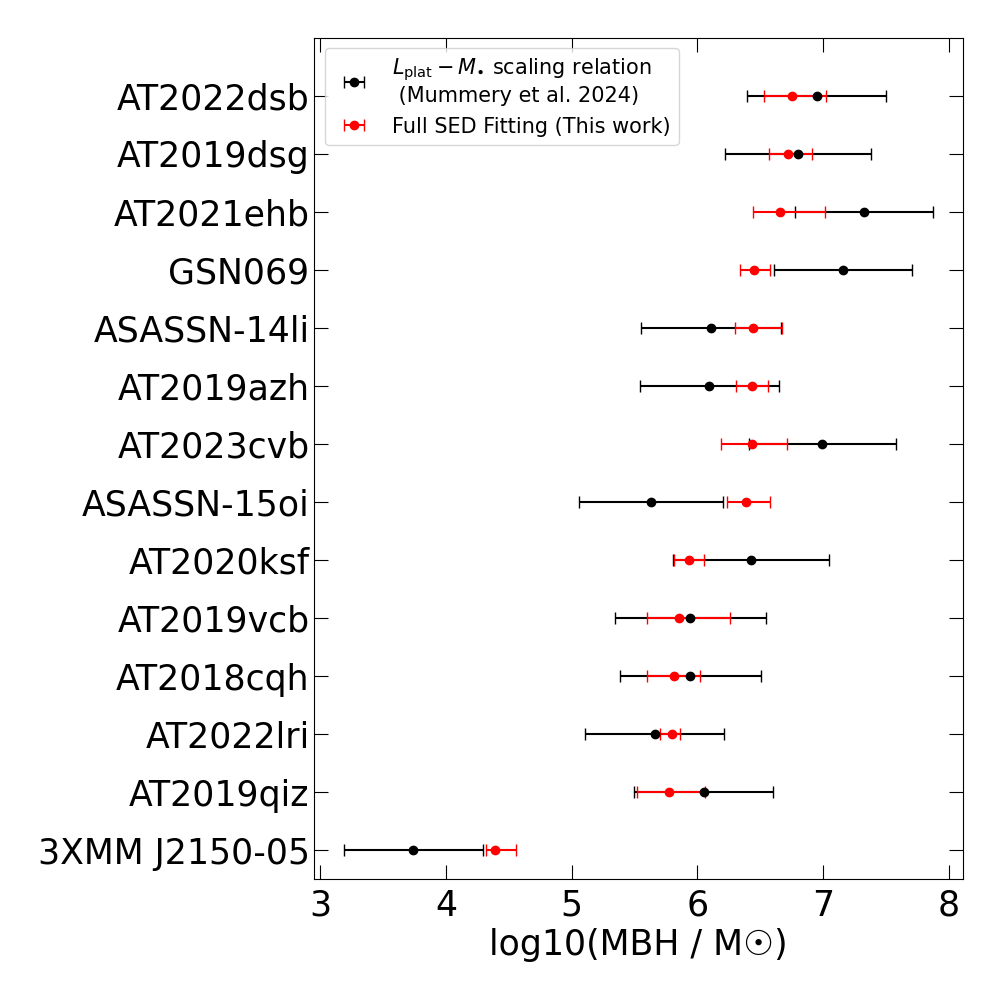

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Function from relation ----
def log_black_hole_mass(logL, sigma_logL, intrinsic_scatter=0.55):
    """
    Estimate log10 BH mass from log10(L_plat), with measurement uncertainty
    and intrinsic ±intrinsic_scatter dex combined.
    """
    logM = 1.50 * (logL - 43) + 8.3
    sigma_logM = np.sqrt((1.5 * sigma_logL)**2 + intrinsic_scatter**2)
    return logM, sigma_logM

# ---- Read table ----
table = pd.read_csv("properties.csv")

# ---- Select epoch closest to dt=1000 with finite log_Lplat ----
selected_rows = (
    table[np.isfinite(table["log_Lplat"])]  # only finite Lplat
         .loc[lambda df: df.groupby("source")["dt"]
                         .apply(lambda x: (x - 1000).abs().idxmin())]
         .reset_index(drop=True)
)

# ---- Compute MBH from Lplat ----
logM, sigma_logM = log_black_hole_mass(
    selected_rows["log_Lplat"].values,
    selected_rows["log_Lplat+"].values
)

selected_rows = selected_rows.copy()
selected_rows["logM_Lplat"] = logM
selected_rows["sigma_logM_Lplat"] = sigma_logM

# ---- Reorder by alternative MBH (log_Mbh) high → low ----
selected_rows = selected_rows.sort_values(by="log_Mbh", ascending=False).reset_index(drop=True)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 10))

ypos = np.arange(len(selected_rows))

# Lplat-based MBH (black, symmetric errors)
ax.errorbar(selected_rows["logM_Lplat"], ypos,
            xerr=selected_rows["sigma_logM_Lplat"], fmt='o',
            color='black', capsize=4, label=r"$L_{\rm plat}-M_{\bullet}$ scaling relation"+str('\n')+" (Mummery et al. 2024)")

# Alternative MBH (red, asymmetric errors)
xerr_alt = [selected_rows["log_Mbh-"].values,
            selected_rows["log_Mbh+"].values]
ax.errorbar(selected_rows["log_Mbh"], ypos,
            xerr=xerr_alt, fmt='o',
            color='red', capsize=4, label="Full SED Fitting (This work)")

# Formatting
ax.set_yticks(ypos)
ax.set_yticklabels(selected_rows["source"])
ax.set_xlabel("log10(MBH / M☉)")

ax.set_ylim(-1, 13.5)
ax.legend(fontsize=15)
ax.invert_yaxis()  # top source on top

plt.tight_layout()
plt.show()


In [28]:
ypos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [11]:
selected_rows

source      dt    dt+    dt-   log_Rin  log_Rin+  log_Rin-  \
0       AT2022dsb  1540.0   75.0   75.0  7.522722  0.121305  0.129727   
1       AT2019dsg   530.0   40.0   40.0  7.640061  0.102865  0.088207   
2       AT2021ehb   480.0   30.0   30.0  7.398469  0.203326  0.155070   
3          GSN069  1600.0   10.0   10.0  7.156349  0.057038  0.054923   
4     ASASSN-14li  1275.0   75.0   75.0  7.479321  0.177730  0.117663   
5       AT2019azh  1100.0  100.0  100.0  7.436902  0.109720  0.062451   
6       AT2023cvb   820.0   60.0   60.0  7.314881  0.228035  0.243453   
7     ASASSN-15oi  1430.0   60.0   60.0  7.397913  0.130535  0.099014   
8       AT2020ksf   990.0   70.0   70.0  7.049008  0.105222  0.097343   
9       AT2019vcb   940.0   50.0   50.0  6.767846  0.378569  0.246025   
10      AT2018cqh  2400.0  100.0  100.0  6.784754  0.140322  0.120206   
11      AT2022lri   990.0   50.0   50.0  6.691991  0.066030  0.074454   
12      AT2019qiz   750.0  150.0  150.0  6.662091  0.100867  0.098628   
13  3XMM J2150-05   179.0    1.0    1.0  5.243391  0.128267  0.053585   

      log_Tp   log_Tp+   log_Tp-  ...  log_Mgal+  log_Mgal-  sigma  sigma+  \
0   5.561650  0.031139  0.032734  ...       0.30       0.30    NaN     NaN   
1   5.179189  0.114131  0.101433  ...       0.10       0.10   86.9     3.9   
2   5.399010  0.043997  0.064330  ...       0.10       0.10   93.0     5.0   
3   5.445217  0.024635  0.016519  ...       0.10       0.10   63.0     4.0   
4   5.322992  0.021820  0.028166  ...       0.20       0.20   81.0     2.0   
5   5.226536  0.043336  0.044188  ...       0.10       0.10   68.0     2.0   
6   5.547553  0.075806  0.056123  ...       0.20       0.20    NaN     NaN   
7   5.149021  0.113167  0.095073  ...       0.10       0.10   81.0     2.0   
8   5.591194  0.029335  0.029986  ...       0.05       0.05   56.0     2.0   
9   5.427461  0.080029  0.071316  ...       0.10       0.10    NaN     NaN   
10  5.555335  0.022791  0.041128  ...       0.10       0.10   53.0    10.0   
11  5.617489  0.033024  0.020272  ...       0.10       0.10   33.0     2.0   
12  5.536244  0.033867  0.031900  ...       0.20       0.20   72.0     2.0   
13  6.181243  0.029946  0.049195  ...       0.40       0.40    NaN     NaN   

    sigma-  log_Lplat  log_Lplat+  log_Lplat-  logM_Lplat  sigma_logM_Lplat  
0      NaN      42.10        0.03        0.03       6.950          0.551838  
1      3.9      42.00        0.12        0.12       6.800          0.578705  
2      5.0      42.35        0.02        0.02       7.325          0.550818  
3      4.0      42.24        0.02        0.02       7.160          0.550818  
4      2.0      41.54        0.06        0.06       6.110          0.557315  
5      2.0      41.53        0.03        0.03       6.095          0.551838  
6      NaN      42.13        0.13        0.13       6.995          0.583545  
7      2.0      41.22        0.10        0.10       5.630          0.570088  
8      2.0      41.75        0.19        0.19       6.425          0.619455  
9      NaN      41.43        0.16        0.16       5.945          0.600083  
10    10.0      41.43        0.07        0.07       5.945          0.559933  
11     2.0      41.24        0.04        0.04       5.660          0.553263  
12     2.0      41.50        0.04        0.04       6.050          0.553263  
13     NaN        NaN         NaN         NaN         NaN               NaN  

[14 rows x 33 columns]